# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data.income == '>50K'].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data.income == '<=50K'].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/float(n_records) *100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

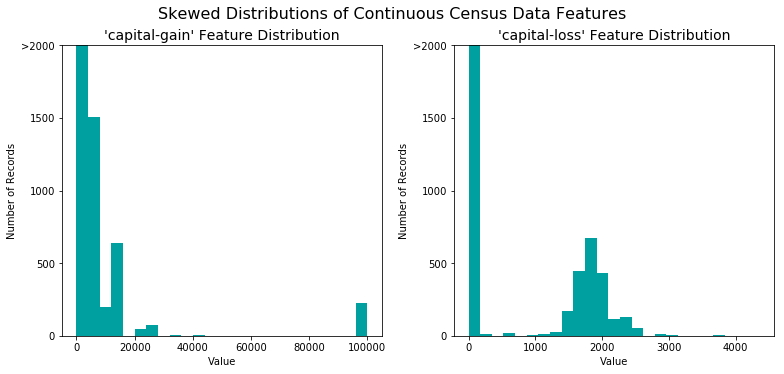

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

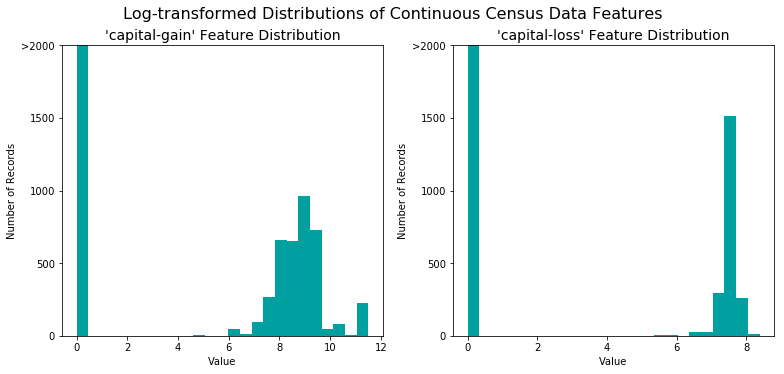

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']

features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [19]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw, prefix='D', prefix_sep="_")

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.replace(to_replace=['<=50K','>50K'],value=[0,1])

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'D_ Federal-gov', 'D_ Local-gov', 'D_ Private', 'D_ Self-emp-inc', 'D_ Self-emp-not-inc', 'D_ State-gov', 'D_ Without-pay', 'D_ 10th', 'D_ 11th', 'D_ 12th', 'D_ 1st-4th', 'D_ 5th-6th', 'D_ 7th-8th', 'D_ 9th', 'D_ Assoc-acdm', 'D_ Assoc-voc', 'D_ Bachelors', 'D_ Doctorate', 'D_ HS-grad', 'D_ Masters', 'D_ Preschool', 'D_ Prof-school', 'D_ Some-college', 'D_ Divorced', 'D_ Married-AF-spouse', 'D_ Married-civ-spouse', 'D_ Married-spouse-absent', 'D_ Never-married', 'D_ Separated', 'D_ Widowed', 'D_ Adm-clerical', 'D_ Armed-Forces', 'D_ Craft-repair', 'D_ Exec-managerial', 'D_ Farming-fishing', 'D_ Handlers-cleaners', 'D_ Machine-op-inspct', 'D_ Other-service', 'D_ Priv-house-serv', 'D_ Prof-specialty', 'D_ Protective-serv', 'D_ Sales', 'D_ Tech-support', 'D_ Transport-moving', 'D_ Husband', 'D_ Not-in-family', 'D_ Other-relative', 'D_ Own-child', 'D_ Unmarried', 'D_ Wife',

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [8]:
from sklearn.metrics import accuracy_score, fbeta_score

naive_data = np.ones(len(y_test))


# TODO: Calculate accuracy
accuracy = accuracy_score(y_test, naive_data)

# TODO: Calculate F-score using the formula above for beta = 0.5
fscore = fbeta_score(y_test, naive_data, .5)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2438, F-score: 0.2872]


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

I wanted to really understand all of these algorithms so I wrote them all up and tested a bunch.  I would love feedback on any gaps in what I've written or errors in my analysis.  I'm going to do the last prompt first because I'm choosing the following three ultimately:

1. AdaBoost w DecisionTree: This is a good candidate because I want to try an ensemble method and I think decision tree could work well with this data given its low dimensionality and categorical nature. 
2. Logisitic Regression: This is a binomial classification problem, we are trying to asses whether a person fits in one category or another which is good for logistic regression.
3. KNN: This is a nice option because it makes intuitive sense that the people with similar characteristics would also have similar salaries (neighbors are alike).  Also the lower dimensionality and categorical nature of the data could work well with KNN.

**Gaussian Naive Bayes**
A type of classified based on bayes’ theorem that assume an independence between features.  Don’t always correctly predict probabilities, but can generally be good classifiers. Especially powerful when the feature class expands.  Briefly, NB allows us to predict a class, given a set of features.

*When to use:* Continuously valued inputs, smaller data set, good in NLP

*Pros:* Only requires a small amount of training data to make predictions. Also avoids the curse of dimensionality as it scales well with many features. Not sensitive to irrelevant features as they don’t affect the classification.

*Cons:* The independence assumption is often false.

*Use Case:*  A spam classifier.  Given a feature set of words, what is the probability that a message is spam or not. In this case you are modeling the probability that a document is of a certain class given that it contains all of the words.

**Decision Trees**
Decision Trees pose a series of questions to data in a node and leaf tree structure to ultimately classify based on the results. The decision tree algorithm works to figure out how to best split the data - in scikit.learn either using the “gini” method or entorpy - and expands the leaf nodes until the decision criteria is met.  Entropy identifies the level of which a set of data is homogenous. If it is totally homogenous, entropy is 0, if equally divided 1.  Information gain is the decrease in entropy after a split is made.  A tree is built until the entropy is a leaf is 0 and a classification can be made.  Random Forest is a way of doing decision trees in an ensemble method.

*When to Use:* Linear decision boundary parallel to axis, low dimensionality

*Pros:*  Trees are easy to understand. Are good at finding interactions - and even “odd” interactions - between variables that won’t be otherwise obvious

*Cons:*  Trees can be highly sensitive to small changes in data and/or choices for root spliting functions. Decision trees don’t work if you have smooth boundaries or a truly linear outcome.  

*Use Case:* In education, decision trees and random forests have been used to predict whether a student is at a high likelihood of  not graduating  on time for early warning.

**Ensemble Methods**
Ensemble methods, in a nutshell, breakdown classification problems into smaller problems with each classifier solving the problem on a subset of data and then those results being combined into an ensemble learner. Techniques include Bagging, Boosting (Adaboost), Random Forest, Each of the classifiers needs to be at least a weak learner, meaning the error metric does better than a random classifier.  Combined these become a strong learner.  One way of constructing an ensemble learner is to manipulate the training data to generate random (or semi_random) subsets and then do repeated trainings on the subsets, averaging the results (see: Bagging).  A bootstrap replicate of the training set is made and this is called bootstrap aggregating. Ensemble methods are best for classifiers that are affected greatly by small changes in the data (decision tree, neural networks, rule-learning - unstable algorithms). Stable algorithms (linear regression, nearest neighbor, and linear threshold - stable algorithms)

*When to use:* Anytime you are using one of the unstable algorithms above it can help, although can generally help in many other scenarios

*Pros:*  Ability to make more robust models on problems than using a single model. Has an efficiency because large scale problems can be broken into smaller problems

*Cons:* Need to have a tool to combine the various hypotheses.  

*Use Case:*  The netflix challenge was a good example of ensemble methods in action. No one could crack the challenge as an individual team, so a variety of teams combined their models into an ensemble and were able to beat the challenge. 

**K-Nearest Neighbors**
K-NN can be used for classification or regression problems.  In classification, the nearest neighbors to the point - defining nearness can be the trick - are used to pick a label. The highest vote among neighbors becomes the label.  In regression, the output variables of the neighbors are combined to create an average which is assigned to the unknown point. Among the simplest of techniques and a lazy learner, all computation is done at classification time. It is common to give weighting to the neighbors, so nearer neighbors can contribute more.

*When to use:* Able to store entire training set, distance between samples is meaningful, low dimensionality

*Pros:* Simple to implement, flexible features and distance choices, doesn’t require probability assumptions

*Cons:* Search problem to find neighbors, must have meaningful distance function, sensitive to localized phenomena, dimensionality can cause lots of neighbors, normalization, 

*Use Case:* K-NN can be used in retail to find like-minded customers and make recommendations on products customers might like, identify shopping patterns and offer coupons

**Stochastic Gradient Descent**
Gradient descent algorithms are designed to minimize an error function through an iterative process of finding optima.  In GD, the entire training sample is used each time the weight adjustment are calculated according to the gradient produced by the learning rate.  This can be slow for large data sets.  In SGD, the weights are adjusted after each sample from the training set, leading to a more zig-zag route but much faster convergence. Ultimately, gradient descent is a tool used in combination with other classifiers/regression techniques to find the optimal solutions. For classification SGD could be used with logistic regression or SVM.  For regression it would generally be used with linear regression. 

*When to Use*: Large data set, need to optimize a parameter for a classifier/regression

*Pros*: Faster than Batch GD when using large data sets, efficiency, ease of use

*Cons*: The need to pick an appropriate step size and other hyperparameter selection, possibility of getting stuck in local optima, sensitive to feature scaling

*Use Case*: Regression problems can use SGD, so any real world problem where regression would make sense.  One regression problem I have seen in the past is predicting the run time of a certain data ingestion procedure based on the features of the source.

**Logistic Regression (Log odds/Logit)**
Logistic regression is a regression model with an output of a discrete variable, often a binary dependent variable that is either 0 or 1.  This is a primary classification method. Multinomial logistic regression can deal with more than two outcome variables. Logistic regression uses a logit transformation - (from Wikipedia) first takes the odds of the event happening for different levels of each independent variable, then takes the ratio of those odds (which is continuous but cannot be negative) and then takes the logarithm of that ratio (this is referred to as logit or log-odds) to create a continuous criterion as a transformed version of the dependent variable. Put another way: logistic regression analysis is based on calculating the odds of the outcome as the ratio of the probability of having the outcome divided by the probability of not having it. (from Quora - Murthy Kollaru). Maximum-likelihood estimation and gradient descent are two learning algorithms used in logistic regression.

When to Use: Binomial classification, output variable that is discrete from continuous input variables

*Pros*: Efficient, Works best with single decision boundary, low variance and less prone to overfitting, better at dealing with high dimension data than decision trees

*Cons*: Sensitive to outliers - they need transformation, can overfit if highly-correlated inputs, requires numeric variables

*Use Case*: A friend of mine works for adroll and his company uses logistic regression to determine whether they should bid on ads on social media.

**Support Vector Machines**
SVMs use support vectors - the samples from the training set that are closest to the boundary line - to determine a hyperplane that will separate the data into two categories.  At first sight, the data doesn’t have to be linearly separable, because SVMs can also use a kernel trick to move the data to a higher dimension where it may be separable. SVMs work on the idea of optimizing the maximal distance from the closest support vectors to the boundary line.  SVMs can also be have hyperparameters that can be tuned to improve fit. C is a parameter that controls in the influence of each SV. The gamma hyperparameter can also be tuned to get the right balance between bias and variance.  A higher gamma leads to high bias and low variance. 

*When to use*: Large number of features and dataset, sparse data, 

*Pros*: Ability to use kernel trick for non-linearity, hyperparameter tuning, robust

*Cons*: A little bit of a black box because of complex transformation possibilities

*Use Case*:  SVMs have been used in the sciences to classify proteins with up to 90% accuracy (wikipedia)

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


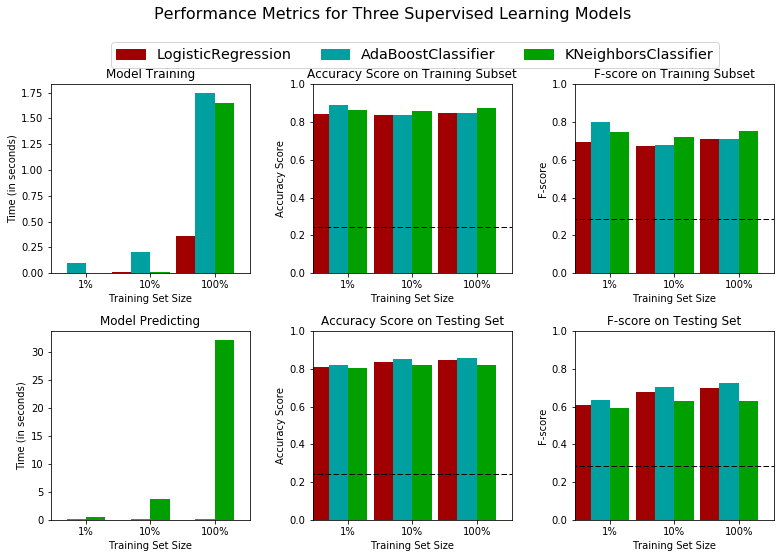

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = AdaBoostClassifier()
clf_B = KNeighborsClassifier()
clf_C = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = len(X_train) / 100
samples_10 = len(X_train) / 10
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **
I am choosing AdaBoost with DecisionTree as the base estimator for the best classifier. There isn't a lot of discrepancy between the models, but the fbeta metric we choose as an evaluation was the highest for AdaBoost across the board.  Training time for AdaBoost on the full training set was much slower than logistic regression, but not slow enough to be a problem as training will not be a repeated cost and the prediction time was low for both logistic regression and AdaBoost. KNN performed well, but across the metrics it wasn't as good as the other two. 

A decision tree is a good algorithm for this data because we are trying to predict a socioeconomic characteristic and decision trees need to have good node splits and my guess is that some of these features do a good job bucketing people into groups (reducing entropy). Boosting with those decision trees is a good choice because boosting helps weak learners like decision trees and because decision trees are relatively fast to train an ensemble method is a good choice.  Finally, decision trees are easier to explain/understand and for a non-profit charity this might be particularly helpful.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 
The model we chose to use to predict the income of your potential donors uses at its base a decision tree.  This model works in an intuitive way, in fact the way many people make their own predictions about the world. Essentially the model is trained on some training data that includes all the feature characteristic of the donors and the information on their income level.  The model takes that data and chooses the characteristics that best split the donors into either the >55K level or below 55K level.  Sometimes this may take many splits of the data until everyone is bucketed into a category.  All of these splits are branches on our decision tree. In our particular model we ramping this method up by taking subsets of the training data and repeatedly building multiple decision trees, each time using more and more of the data that is the hardest to classify.  At the end of the process we end up with a bunch of decisions trees, each one trained with a slightly different set of the training data.  When we want to make a prediction on someone whose income we don't know, we run their characterstics through ALL of the decision trees producing multiple predictions and the category that comes up the most often is our final prediction.  This is more powerful than building a single decision tree and using that for all the predictions.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [16]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = AdaBoostClassifier()

# TODO: Create the parameters list you wish to tune
#parameters = {'n_estimators':(25,50,75,100), 'learning_rate':(.25.,.5,1,10)}
#parameters = {'n_estimators':(100,150), 'learning_rate':(1,10,20)}
parameters = {'n_estimators':(150,1000), 'learning_rate':(1,10,20)}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8676
Final F-score on the testing data: 0.7448


In [15]:
best_params = grid_fit.best_params_
print best_params

{'n_estimators': 150, 'learning_rate': 1}


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     .243            |    .857           |       .8606     |
| F-score        |      .287           |     .7246         |   .7316         |


**Answer: **

The scores of the optimized model were better than the unoptimized model, although only marginally. I tuned the n_estimators and learning_rate parameters and the optimal parameters - from the ones I opted to test - were n_estimators = 100 and learning_rate = 1.  It makes sense that raising the number of estimators, or iterations of boosting, would improve accuracy.  I tried with a variety of options, and the learning rate of 1 was always the best but the higher number of estimators produced better scores. Again, it didn't improve scores radically, making me think that if this data set was expanded the extra expense of running so many estimators might not be worth the improvement.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**
1. Occupation
2. Education Num
3. Age
4. Race
5. Gender

I think most people earn money from their occupations, and there tends to be a fairly bounded range of salaries for certain occupations.  Education I also feel would positively correlate strongly with income, at least to the 55K cutoff.  Age generally raises a person's income as the more work tenure they have the higher their salary generally. Unfortunately, I also think race and gender are factors that will have stronger predictive power.  If the cutoff was higher, say 150K, then I would have put the capital gains higher.  But at 55K, I don't think capital gains will be as telling as other features.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

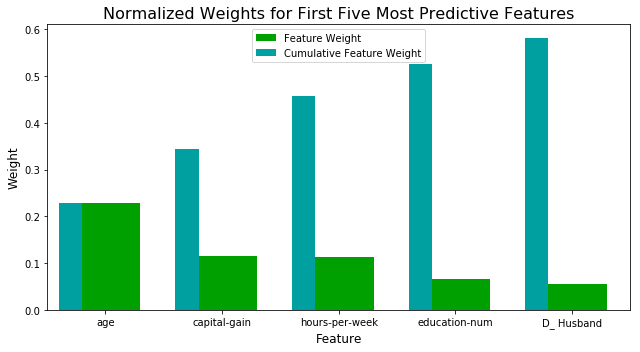

In [18]:
# TODO: Import a supervised learning model that has 'feature_importances_'
#using random forest to switch things up, already imported above as I was testing

# TODO: Train the supervised model on the training set 
model = RandomForestClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**
Interesting, I only chose two of the five. Age for me does make sense, although I wouldn't have guessed it to be the highest predictive power.  I did mention capital gains, although I didn't think it would have more importance than education_num.  I should have figured hours-per-week because that is essentially a proxy if someone works full-time, part-time, or not at all.  I'm surprised occupation didn't have that much power, although with one-hot encoding there may have been so many distinct occupations and individual one doesn't predict that much.  I didn't take that into account.  Being a husband means you are both a man and married, which I think is interlated to being older as well as the average marrying age is around 26 I believe.  So gender is buried in there a bit.  That race is not listed makes me happy :)

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [46]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8676
F-score on testing data: 0.7448

Final Model trained on reduced data
------
Accuracy on testing data: 0.8444
F-score on testing data: 0.6973


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**
They scores are fairly close, both within 2 to 5 hundredths.  The full data testing data is more accurate on both scores, which makes sense as we only selected 5 features that accounted for half of the predictive importance.  If training time was a MAJOR factor I would consider using the reduce data as a training set.  I probably would be more likely to go with a reduced training set if there were more operational costs in getting the data needed for a making a new prediction.  If we weren't able to gather all 13 features on every donor, maybe we could just focus on doing a good job of gathering data on the six most important features so that our data is more complete and reliable.  That is where I would see knowing the importance of the features as more valuable because data collection for many organizations is one of the hardest aspects of analytics and a prediction is only as good as the data that goes into training the model and when the model is used.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.